# MCMC and PyMC SIMPLE examples

[NOTE: This notebooks is heavily inspired in the book ThinkBayes 2, chapter 19 MCMC]

## Solving the World Cup problem.


>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Before you can answer a question like this, you have to make some modeling decisions.  Scoring in games like soccer can be well modeled by a Poisson process, which assumes that each team, against a given opponent, will score goals at some goal-scoring rate, λ, and that this rate is stationary; in other words, the probability of scoring a goal is about the same at any point during the game.

If this model holds, we expect the distribution of time between goals to be exponential, and the distribution of goals per game to be Poisson.

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import arviz as az
import matplotlib as mt
mt.style.use("ggplot")
import numpy as np
import pandas as pd
import pymc as pm
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [20]:
avg_goals_per_team = 1.34
duration_of_game = 93.

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [lambda_]
>Metropolis: [pred]


Output()

Sampling 1 chain for 0 tune and 25_000 draw iterations (0 + 25_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


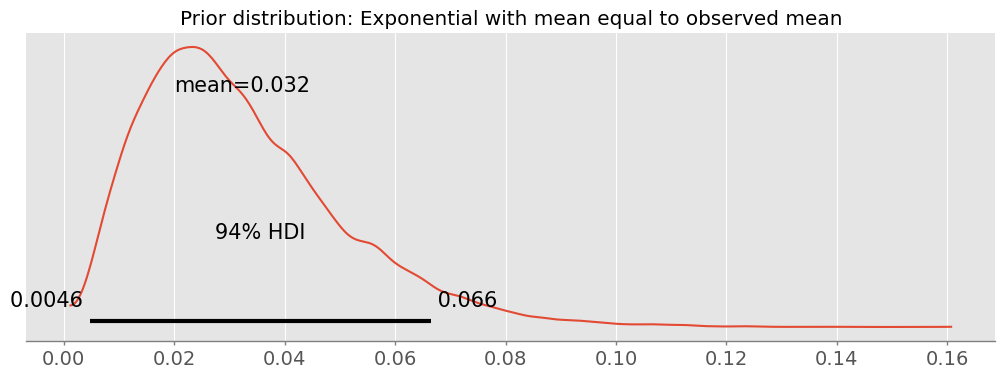

In [40]:
with pm.Model() as model:
    lambda_ = pm.Exponential('lambda_', duration_of_game/avg_goals_per_team)
    duration_between_goals = [11, 12]
    obs = pm.Exponential('obs', lambda_, observed=duration_between_goals)
    prediction = pm.Poisson('pred', (duration_of_game-23)*lambda_)
    trace = pm.sample(25000, chains=1, tune=0, progressbar=True)

az.plot_posterior(trace, var_names=["lambda_"])
plt.title('Prior distribution: Exponential with mean equal to observed mean')
plt.show();

Text(0.5, 0, 'Number of goals')

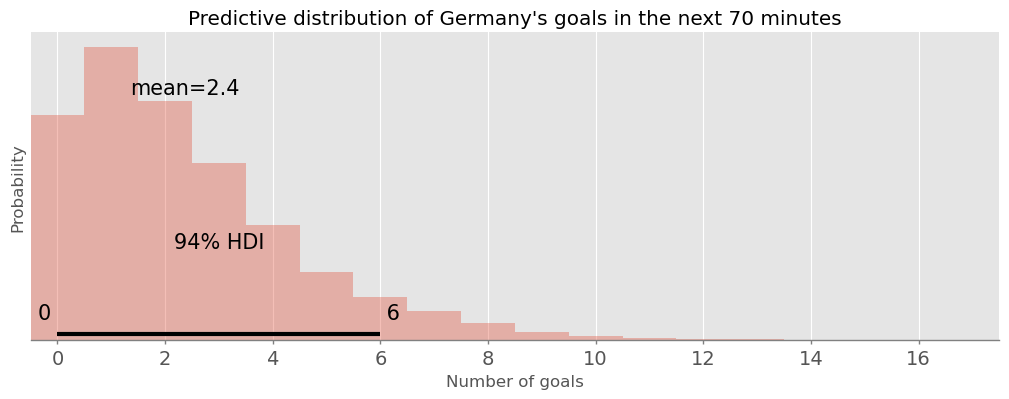

In [39]:
az.plot_posterior(trace, var_names=["pred"])
plt.title("Predictive distribution of Germany's goals in the next 70 minutes")
plt.ylabel('Probability')
plt.xlabel('Number of goals')

## Happiness

Recently I read ["Happiness and Life Satisfaction"](https://ourworldindata.org/happiness-and-life-satisfaction)
by Esteban Ortiz-Ospina and Max Roser, which discusses (among many other things) the relationship between income and happiness, both between countries, within countries, and over time.

It cites the ["World Happiness Report"](https://worldhappiness.report/), which includes [results of a multiple regression analysis](https://worldhappiness.report/ed/2020/social-environments-for-world-happiness/) that explores the relationship between happiness and six potentially predictive factors:

* Income as represented by per capita GDP

* Social support

* Healthy life expectancy at birth

* Freedom to make life choices

* Generosity

* Perceptions of corruption


The dependent variable is the national average of responses to the "Cantril ladder question" used by the [Gallup World Poll](https://news.gallup.com/poll/122453/understanding-gallup-uses-cantril-scale.aspx):

> Please imagine a ladder with steps numbered from zero at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?

I'll refer to the responses as "happiness", but it might be more precise to think of them as a measure of satisfaction with quality of life.



In [4]:
import pandas as pd

filename = 'WHR20_DataForFigure2.1.xls'
df = pd.read_excel('./data/' + filename)

In [5]:
df.head(3)

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267


The `DataFrame` has one row for each of 153 countries and one column for each of 20 variables.

The column called `'Ladder score'` contains the measurements of happiness we will try to predict.

In [6]:
score = df['Ladder score']

### Multiple Regression

Before we implement the multiple regression model, I'll select the columns we need from the `DataFrame`.

In [7]:
columns = ['Ladder score',
           'Logged GDP per capita',
           'Social support',
           'Healthy life expectancy',
           'Freedom to make life choices',
           'Generosity',
           'Perceptions of corruption']

subset = df[columns]

In [8]:
subset.head(3)

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,7.8087,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445
1,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489
2,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728


The predictive variables have different units: log-GDP is in log-dollars, life expectancy is in years, and the other variables are on arbitrary scales.
To make these factors comparable, I'll standardize the data so that each variable has mean 0 and standard deviation 1.

In [17]:
subset_standerized = subset - subset.mean()
subset_standerized = subset_standerized / subset.std()
subset_standerized.head(3)

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,2.099724,1.118155,1.198886,1.056313,1.407737,-0.295857,-3.069408
1,1.953087,1.230285,1.212563,1.127394,1.427026,0.532052,-3.223286
2,1.876037,1.401668,1.104339,1.368253,1.171414,0.793626,-2.451252


In [18]:
predictors = columns[1:]

In [13]:
import pymc as pm
import numpy as np

with pm.Model() as hapiness_regression:
    predictors = columns[1:]
    n_predictors = len(predictors)
    n_samples = len(subset_standerized)
    # Priors
    beta = pm.Normal('beta', mu=0, sigma=1, shape=n_predictors)
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    # Likelihood
    mu = alpha + pm.math.dot(subset_standerized[predictors], beta)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=subset['Ladder score'])
    # Posterior
    trace = pm.sample(2000, tune=1000, chains=2, cores=2, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


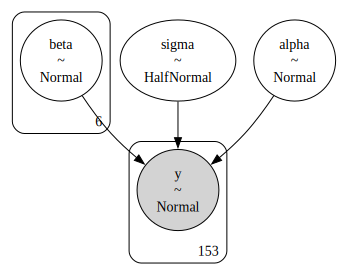

In [16]:
pm.model_to_graphviz(hapiness_regression)


In [14]:
import arviz as az

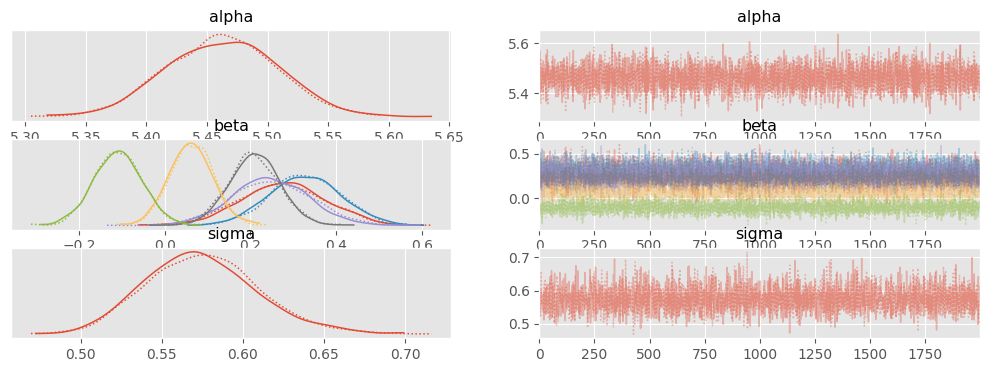

In [15]:
az.plot_trace(trace, var_names=["alpha", "beta", "sigma"], figsize=(12.5, 4))
plt.show()

## School Scoring

We want to model test scores 
$ y_ij $
​, where:

$i$ is the student

$j$ is the school

Each school has a different average score, but they all come from a common population.

In [19]:
#Data Simulation


np.random.seed(42)

n_schools = 10
students_per_school = 20

# Hyperparameters
mu_0 = 75        # National average score
tau = 5          # Standard deviation across schools
sigma = 10       # Noise within each school

# School-level means
school_means = np.random.normal(mu_0, tau, size=n_schools)

# Generate student scores
data = []
for j in range(n_schools):
    scores = np.random.normal(school_means[j], sigma, size=students_per_school)
    data.extend([(j, score) for score in scores])

df = pd.DataFrame(data, columns=["school", "score"])


In [21]:
df.head(3)

,school,score
0,0,72.849394
1,0,72.826273
2,0,79.903193


In [28]:
# Build the PyMC Model
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_0 = pm.Normal("mu_0", mu=75, sigma=10)
    tau = pm.HalfNormal("tau", sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)

    # School-level means
    school_means = pm.Normal("school_means", mu=mu_0, sigma=tau, shape=n_schools)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=school_means[df["school"]], sigma=sigma, observed=df["score"])

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, chains=2, cores=2, return_inferencedata=True)
    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_0, tau, sigma, school_means]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


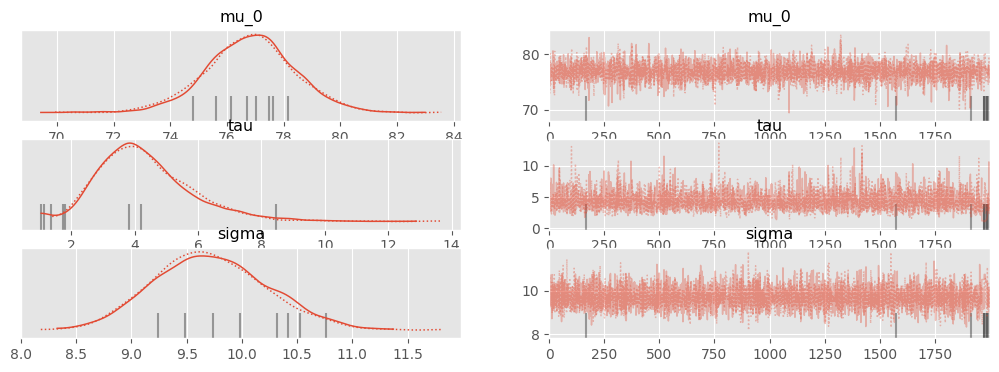

In [27]:
az.plot_trace(trace, var_names=["mu_0", "tau", "sigma"], figsize=(12.5, 4))
plt.show()

In [11]:

    # Inference
